In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration

In [23]:
BASE_PATH = "/data/saturation/thesis_run_20250223/"

# Simulation IDs for the training set
MIN_SIMULATION_ID = 1
MAX_SIMULATION_ID = 150
simulation_ids = list(range(MIN_SIMULATION_ID, MAX_SIMULATION_ID + 1))

N_NSTATS = 100

FONT_SIZE = 20
DPI = 400
IMAGE_TYPE = "png"

# Estimates of slope for each simulation

In [24]:
configs_df = read_configs_pandas(base_path=BASE_PATH)
configs_dict = configs_df.set_index("simulation_id").to_dict(orient="index")

In [25]:
states_sub_dfs = []
for simulation_id in simulation_ids:
    state = pd.read_parquet(f"data/states_{simulation_id}_{N_NSTATS}.parquet")
    states_sub_dfs.append(state)
states = pd.concat(states_sub_dfs, axis=0)
del states_sub_dfs

In [26]:
slope_estimates = []
for simulation_id in simulation_ids:
    state = states.loc[simulation_id].copy()
    mle_slope, sigma = estimate_cumulative_slope(
        radii=state.radius,
        rmin=configs_dict[simulation_id]["rstat"],
        rmax=configs_dict[simulation_id]["rmax"],
        min_search_slope=-10.0,
        max_search_slope=-1
    )

    result = {
        "simulation_id": simulation_id,
        "b_p": configs_dict[simulation_id]["slope"],
        "exponent": configs_dict[simulation_id]["rim_erasure_method"]["exponent"],
        "mle_slope": mle_slope,
        "mle_slope_sigma": sigma
    }
    slope_estimates.append(result)
    
df = pd.DataFrame.from_dict(slope_estimates, orient="columns")

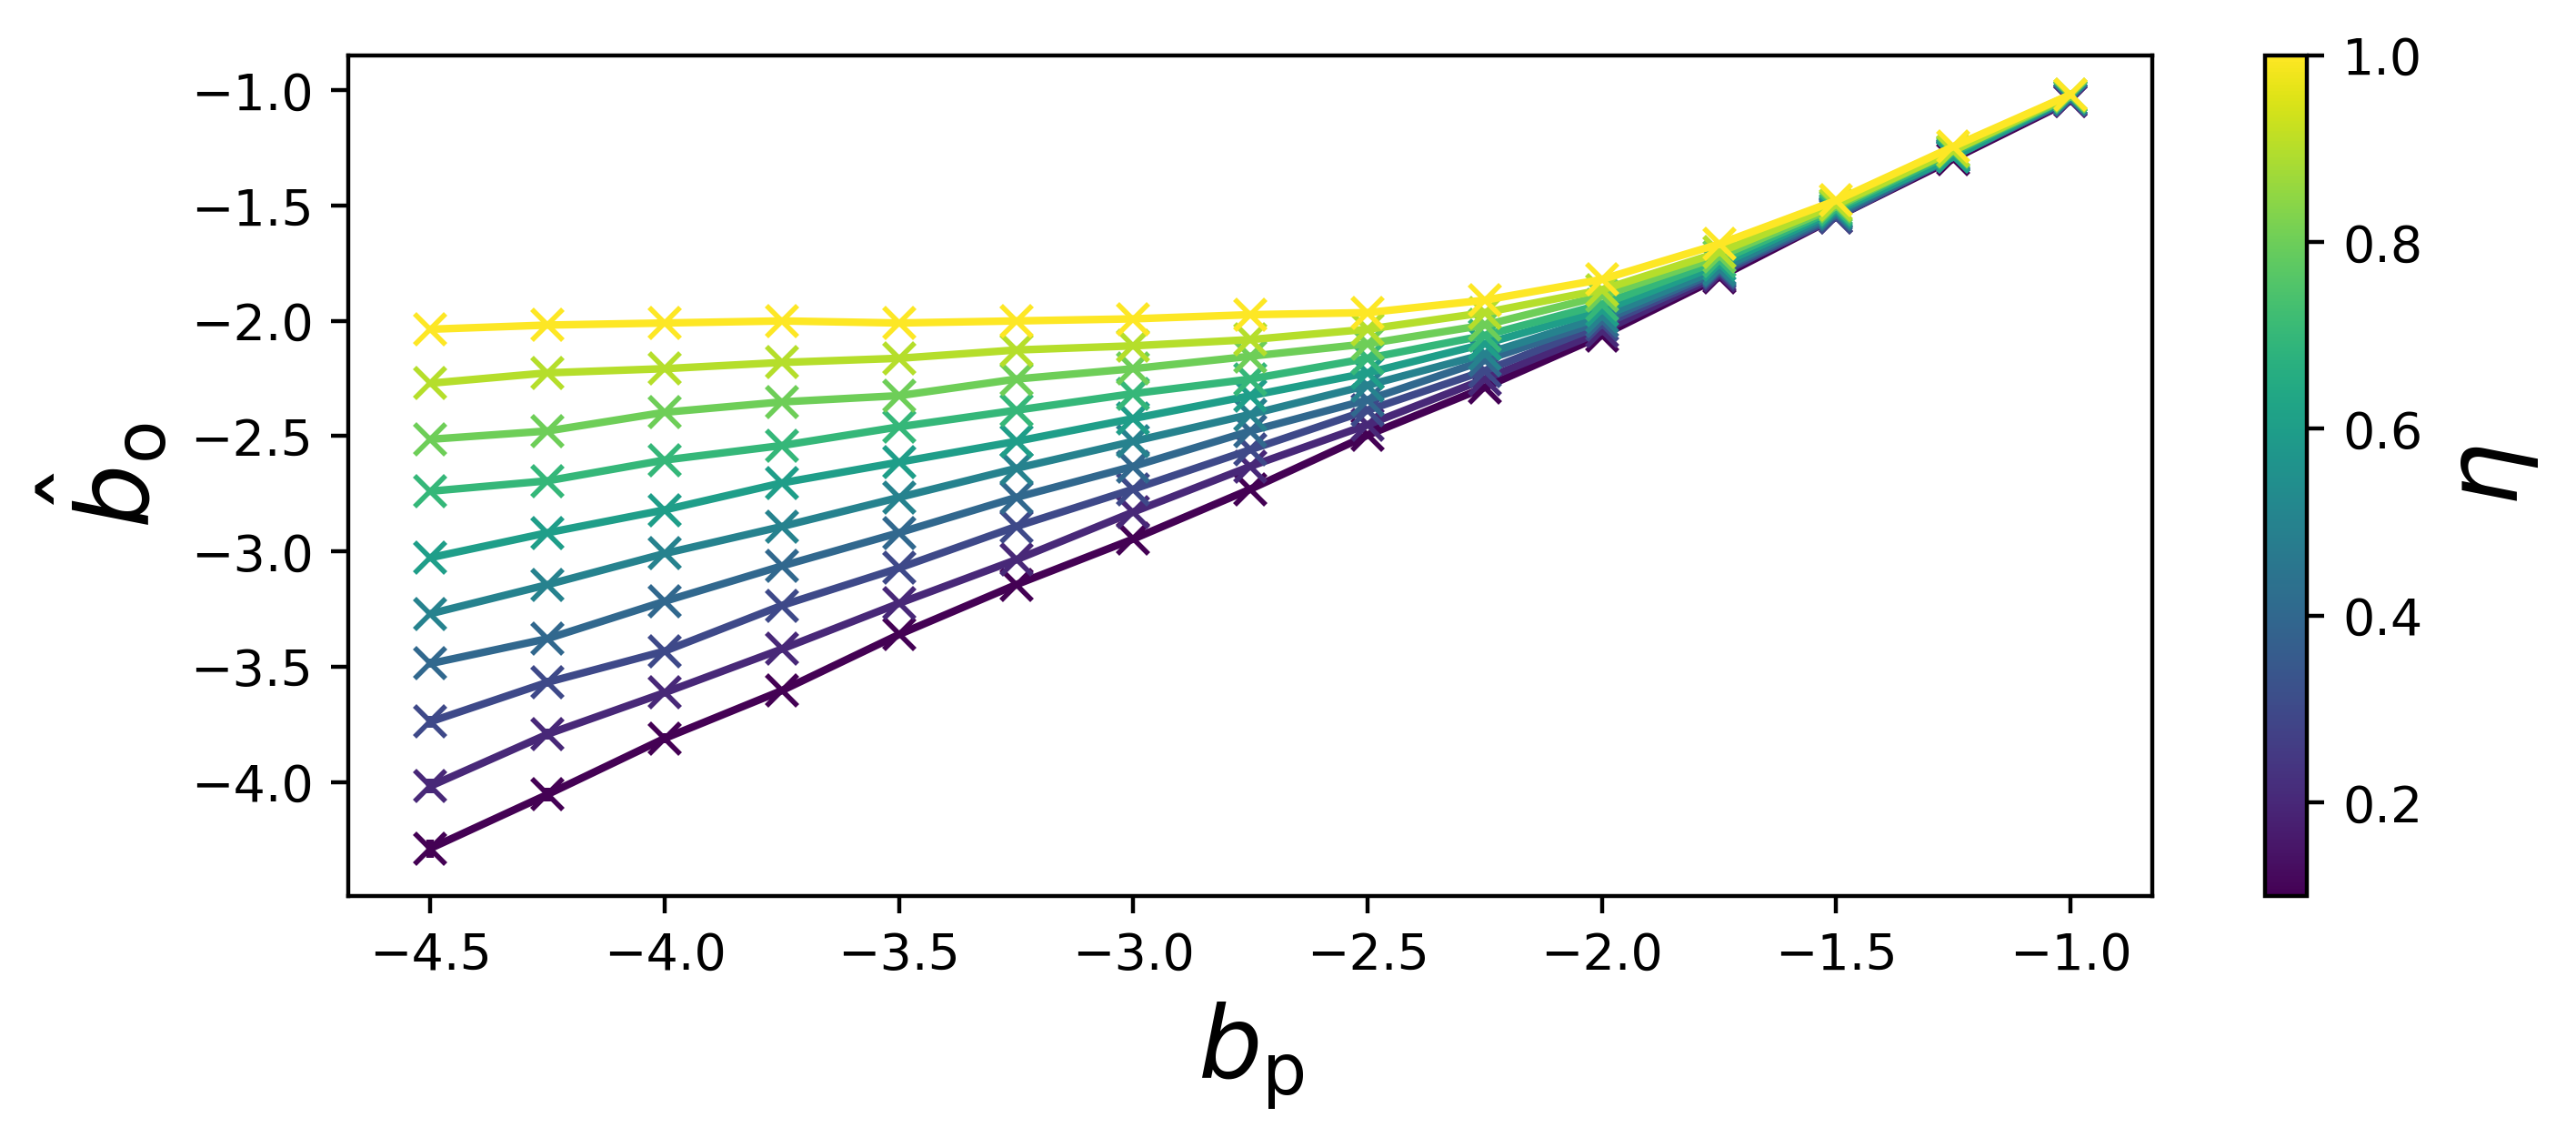

In [27]:
fig = plt.figure(figsize=(8, 3), dpi=DPI)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(df["exponent"].min(), df["exponent"].max())

for exponent in df.exponent.drop_duplicates().sort_values():
    d = df[df.exponent == exponent].sort_values("b_p").copy()
    ax.errorbar(
        d.b_p,
        d.mle_slope,
        d.mle_slope_sigma,
        marker="x",
        # ls="",
        color=cm.viridis(norm(exponent)),
        ecolor=cm.viridis(norm(exponent))
    )

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\eta$", fontsize=FONT_SIZE)

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=FONT_SIZE)
ax.set_ylabel(r"$\hat{b}_{\text{o}}$", fontsize=FONT_SIZE)

plt.savefig(f"figures/mle_estimated_slopes_{N_NSTATS}_nstat.{IMAGE_TYPE}", bbox_inches="tight")

plt.show()

In [19]:
states.reset_index()[["simulation_id", "crater_id"]].nunique()

simulation_id         150
crater_id        36474770
dtype: int64

In [20]:
df = states.reset_index()[["simulation_id", "crater_id", "nstat"]].copy()

# Count how many nstat levels each crater_id appears in per simulation
crater_nstat_counts = df.groupby(["simulation_id", "crater_id"]).agg(nstat_count=("nstat", "nunique")).reset_index()

# Mark duplicates (crater_ids appearing in more than one nstat per simulation)
duplicates = crater_nstat_counts[crater_nstat_counts["nstat_count"] > 1]

# Merge back to original dataframe to count total appearances across nstat levels
duplicates_expanded = pd.merge(df, duplicates[["simulation_id", "crater_id"]], on=["simulation_id", "crater_id"], how="inner")

# Count total occurrences (including repeated nstat levels)
total_duplicates_counts = duplicates_nstat_counts = duplicates.groupby("simulation_id")["nstat_count"].sum().reset_index(name="total_duplicate_nstat_occurrences")

# Merge summaries
summary = crater_nstat_counts.groupby("simulation_id").agg(
    total_craters=("crater_id", "nunique"),
    duplicate_craters=("nstat_count", lambda x: (x > 1).sum())
).merge(total_duplicates_counts, on="simulation_id")

In [10]:
# summary = summary.set_index("simulation_id")
summary["n"] = states.groupby("simulation_id").count().crater_id
summary["percent_dupes"] = (summary.total_duplicate_nstat_occurrences - summary.duplicate_craters) / summary.n

In [11]:
summary.sort_values("percent_dupes")

,simulation_id,total_craters,duplicate_craters,total_duplicate_nstat_occurrences,n,percent_dupes
100,132,98139,1,2,608526.0,0.000002
30,54,186547,1,2,413467.0,0.000002
105,140,102612,1,2,406081.0,0.000002
104,139,100569,1,2,394666.0,0.000003
103,138,99852,2,4,382837.0,0.000005
...,...,...,...,...,...,...
22,39,338087,14358,37274,37930.0,0.604166
43,70,579740,67557,158734,108464.0,0.840620
4,10,258089,15559,50935,31653.0,1.117619
23,40,419552,33553,94432,50763.0,1.199279


(array([84., 10.,  3.,  1.,  3.,  1.,  0.,  1.,  0.,  2.]),
 array([1.64331516e-06, 1.19929379e-01, 2.39857115e-01, 3.59784851e-01,
        4.79712587e-01, 5.99640323e-01, 7.19568059e-01, 8.39495795e-01,
        9.59423531e-01, 1.07935127e+00, 1.19927900e+00]),
 <BarContainer object of 10 artists>)

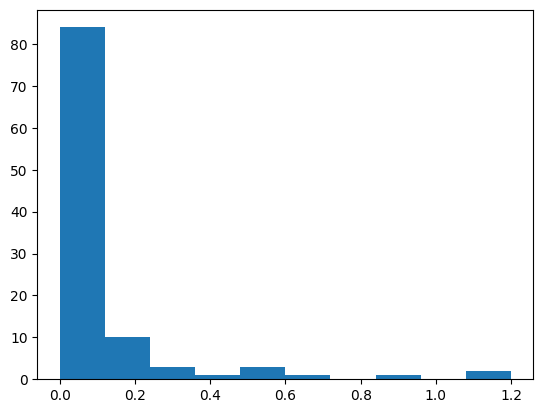

In [12]:
plt.hist(summary.percent_dupes)